#### Apply linear and logistic regression models on rolling returns and its moments 

In [31]:
import pandas as pd
import numpy as np 
import yfinance as yf 
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [32]:
def get_df(values_df, ret_type, window, forward):
    ret_df = values_df.pct_change().dropna(axis=0, how='any').reset_index(drop=True).rename(columns={'prices':'returns'})
    ret_df['mean_rolling_rets'] = ret_df['returns'].rolling(window=window).mean()
    ret_df['std_rolling_rets']  = ret_df['returns'].rolling(window=window).std()
    ret_df['skew_rolling_rets'] = ret_df['returns'].rolling(window=window).skew()
    ret_df['kurt_rolling_rets'] = ret_df['returns'].rolling(window=window).kurt()
    ret_df = ret_df.dropna(axis=0, how='any').reset_index(drop=True)
    if ret_type == 'fwd_rets': 
        ret_df['result'] = ret_df['returns'].shift(forward)/ret_df['returns'] - 1 
    elif ret_type == 'flag':
        ret_df['result'] = np.where(ret_df['returns'].shift(forward) >= ret_df['returns'], 1, 0)
    else:
        return None 
    
    ret_df = ret_df.iloc[forward:, :].reset_index(drop=True)
    
    return ret_df

In [33]:
def apply_lin_regr_model(values_df, sample): 
    X, Y = values_df.drop(['result'], axis=1), values_df['result'].copy()
    train_param_df, test_param_df, train_result_df, test_result_df = train_test_split(X, Y, test_size=sample, random_state=1)
    
    print("Test Sample Size : {}".format(sample))
    print("Training set (param/result): {} {}".format(len(train_param_df), len(train_result_df)))
    print("Testing set (param/result): {} {}".format(len(test_param_df), len(test_result_df)))
    
    train_param_df  = train_param_df.replace([-np.inf, np.inf], np.nan).fillna(0)
    test_param_df   = test_param_df.replace([-np.inf, np.inf], np.nan).fillna(0)
    train_result_df = train_result_df.replace([-np.inf, np.inf], np.nan).fillna(0)
    test_result_df  = test_result_df.replace([-np.inf, np.inf], np.nan).fillna(0)
    
    lr_m = LinearRegression()
    lr_m.fit(train_param_df, train_result_df)
    result_df = pd.DataFrame({'pred_result':lr_m.predict(test_param_df)})
    result_df['test_result'] = test_result_df.tolist()
    result_df = result_df[['test_result', 'pred_result']]
    result_df.plot(x='test_result', y='pred_result', kind='scatter', grid=True, title='Scatter plot - Actual/Predicted')
    
    return round(mean_squared_error(result_df['test_result'], result_df['pred_result']), 4), round(r2_score(result_df['test_result'], result_df['pred_result']), 4)

In [34]:
def apply_log_regr_model(values_df, sample):
    X, Y = values_df.drop(['result'], axis=1), values_df['result'].copy()
    train_param_df, test_param_df, train_result_df, test_result_df = train_test_split(X, Y, test_size=sample, random_state=1)
    
    print("Test Sample Size : {}".format(sample))
    print("Training set (param/result): {} {}".format(len(train_param_df), len(train_result_df)))
    print("Testing set (param/result): {} {}".format(len(test_param_df), len(test_result_df)))
    
    train_param_df  = train_param_df.replace([-np.inf, np.inf], np.nan).fillna(0)
    test_param_df   = test_param_df.replace([-np.inf, np.inf], np.nan).fillna(0)
    train_result_df = train_result_df.replace([-np.inf, np.inf], np.nan).fillna(0)
    test_result_df  = test_result_df.replace([-np.inf, np.inf], np.nan).fillna(0)
    
    lg_m = LogisticRegression()
    lg_m.fit(train_param_df, train_result_df)
    result_df = pd.DataFrame({'pred_result': lg_m.predict(test_param_df)})
    result_df['test_result'] = test_result_df.tolist() 
    result_df = result_df[['test_result', 'pred_result']]
    
    return round(accuracy_score(result_df['test_result'], result_df['pred_result']), 4), confusion_matrix(result_df['test_result'], result_df['pred_result'])
    
    

In [35]:
def return_random_values(size=100):
    values_df = pd.DataFrame({'prices': np.random.randint(10, 100, size=size)})
    
    return values_df

In [36]:
def return_price_values(symbol, start_date, end_date):
    df = yf.download(symbol, start_date, end_date)
    adj_closes = df['Adj Close'].copy() 
    adj_closes = adj_closes.to_frame().rename(columns={'Adj Close':'prices'})
    
    return adj_closes 

In [37]:
def calc(*args):
    arg_values = [ arg for arg in args ]
    if arg_values[0] == 'random':
        data_type = arg_values[1]
        values_df = return_random_values(size=arg_values[2])
        test_size, window, forward = arg_values[3], arg_values[4], arg_values[5]

    elif arg_values[0] == 'symbol':
        data_type = arg_values[1]
        symbol, start_date, end_date = arg_values[2], arg_values[3], arg_values[4]
        values_df = return_price_values(symbol, start_date, end_date)
        test_size, window, forward = arg_values[5], arg_values[6], arg_values[7]
    else:
        print("Incorrect Parameters")
        return False
 
    values_df = get_df(values_df, data_type, window, forward)
    if len(values_df):
        print("Length of the dataframe: {}".format(len(values_df)))
        if data_type == 'fwd_rets': 
            mean_sq_err, r2_err = apply_lin_regr_model(values_df, test_size)
            print("Mean Square Error: {}, R2 Error : {}".format(mean_sq_err, r2_err))
        elif data_type == 'flag': 
            acc_score, confusion_matrix = apply_log_regr_model(values_df, test_size)
            print("Accuracy Score : {}".format(acc_score)) 
            print(confusion_matrix)
        else:
            print("Incorrect data_type value for model specification")
        
    return True

Length of the dataframe: 980
Test Sample Size : 0.25
Training set (param/result): 735 735
Testing set (param/result): 245 245
Mean Square Error: 234.6797, R2 Error : -0.0321


True

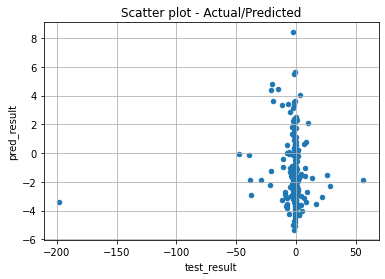

In [45]:
calc('random', 'fwd_rets', 1000, 0.25, 10, 10)

[*********************100%***********************]  1 of 1 completed
Length of the dataframe: 1608
Test Sample Size : 0.25
Training set (param/result): 1206 1206
Testing set (param/result): 402 402
Mean Square Error: 667.4222, R2 Error : -0.0104


True

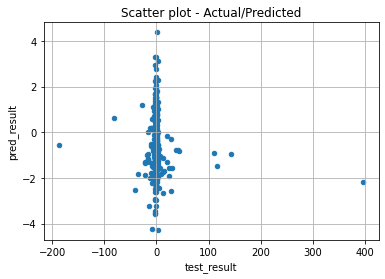

In [39]:
calc('symbol', 'fwd_rets', 'AAPL', '2015-01-01', '2021-06-20', 0.25, 10, 10)

[*********************100%***********************]  1 of 1 completed
Length of the dataframe: 1613
Test Sample Size : 0.25
Training set (param/result): 1209 1209
Testing set (param/result): 404 404
Mean Square Error: 138.115, R2 Error : 0.0026


True

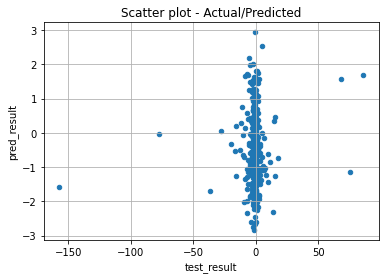

In [40]:
calc('symbol', 'fwd_rets', 'AAPL', '2015-01-01', '2021-06-20', 0.25, 10, 5)

In [41]:
calc('symbol', 'flag', 'AAPL', '2015-01-01', '2021-06-20', 0.25, 10, 10)

[*********************100%***********************]  1 of 1 completed
Length of the dataframe: 1608
Test Sample Size : 0.25
Training set (param/result): 1206 1206
Testing set (param/result): 402 402
Accuracy Score : 0.602
[[ 50 152]
 [  8 192]]


True

In [42]:
calc('symbol', 'flag', 'AAPL', '2015-01-01', '2021-06-20', 0.25, 10, 5)

[*********************100%***********************]  1 of 1 completed
Length of the dataframe: 1613
Test Sample Size : 0.25
Training set (param/result): 1209 1209
Testing set (param/result): 404 404
Accuracy Score : 0.6931
[[151  51]
 [ 73 129]]


True

In [43]:
calc('symbol', 'flag', 'MSFT', '2015-01-01', '2021-06-20', 0.25, 10, 10)

[*********************100%***********************]  1 of 1 completed
Length of the dataframe: 1608
Test Sample Size : 0.25
Training set (param/result): 1206 1206
Testing set (param/result): 402 402
Accuracy Score : 0.5771
[[148  43]
 [127  84]]


True

In [44]:
calc('symbol', 'flag', 'MSFT', '2015-01-01', '2021-06-20', 0.25, 10, 5)

[*********************100%***********************]  1 of 1 completed
Length of the dataframe: 1613
Test Sample Size : 0.25
Training set (param/result): 1209 1209
Testing set (param/result): 404 404
Accuracy Score : 0.6386
[[158  34]
 [112 100]]


True